In [1]:
from torchvision import datasets, transforms
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import math
sns.set()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [3]:
trainset = datasets.CIFAR10(root='cifar10', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

testset = datasets.CIFAR10(root='cifar10', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class BasicBlock(nn.Module):
    
    def __init__(self, ch_in, ch_out, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(ch_out)
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ch_out)
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or ch_in != ch_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(ch_out)
            )

    def forward(self, x):
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = self.conv1(x)
        out = self.bn2(self.conv2(F.relu(self.bn1(out))))
        out += shortcut
        return F.relu(out)

In [5]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.make_group_layer(16, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_group_layer(16, 32, num_blocks[1], stride=2)
        self.layer3 = self.make_group_layer(32, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def make_group_layer(self,ch_in, ch_out, num_blocks, stride):
        layers = [BasicBlock(ch_in, ch_out, stride)]
        for i in range(num_blocks-1):
            layers.append(BasicBlock(ch_out, ch_out, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out))

In [6]:
def find_lr(model, train_dl, epochs=1, start=1e-4, end=8.0, beta=0.95, momentum=0.99, decay=0):
    optimizer = optim.SGD(model.parameters(), lr=start, momentum=momentum, weight_decay=decay)
    avg_loss, best_loss = 0, float('inf')
    step = (end / start) ** (1/(len(train_dl) * epochs - 1))
    i, lr = 1, start
    lr_losses = []
    for _ in range(epochs):
        for data, labels in train_dl:
            input, target = Variable(data).cuda(), Variable(labels).cuda()
            model.zero_grad()
            optimizer.zero_grad()
            output = model(input)
            loss = F.nll_loss(output, target)
            avg_loss = beta * avg_loss + (1-beta) * loss.data.item()
            smoothed_loss = avg_loss / (1 - beta ** i)
            lr_losses.append((lr, smoothed_loss, loss.data.item()))
            if smoothed_loss > 4 * best_loss:
                return lr_losses
            elif smoothed_loss < best_loss:
                best_loss = smoothed_loss
            loss.backward()
            optimizer.step()
            lr *= step
            optimizer.param_groups[0]['lr'] = lr
            i += 1
    return lr_losses

In [7]:
model = ResNet([9,9,9]).cuda()
lr_losses = find_lr(model, trainloader, epochs=1, start=1e-4, end=1e1, momentum=0.95, decay=1e-4)

/home/lucent/.pyenv/versions/3.7.0/envs/ml2/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


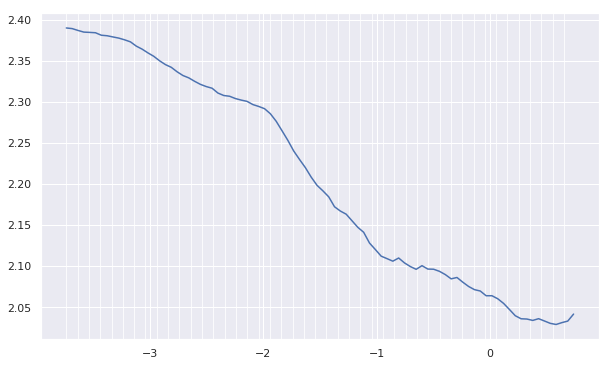

In [8]:
xs, ys = ([math.log10(p[0]) for p in lr_losses[5:-5]], [p[1] for p in lr_losses[5:-5]])
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
s = np.arange(min(xs), max(xs), 0.1)
ax.set_xticks(s, minor=True)
ax.grid(which='minor', alpha=0.8)
ax.plot(xs, ys)